In [ ]:
"""
================================================================================
⚠️ IMPORTANT INSTRUCTIONS FOR TEAM MEMBERS
================================================================================

1️⃣ COCO Dataset Download:
   - The full 'train2017' image dataset (~25 GB) cannot be uploaded to GitHub.
   - Each team member must manually download it from Kaggle:
       https://www.kaggle.com/datasets/awsaf49/coco-2017-dataset
   - Extract the zip files into your local folder structure:

       coco-captioning/
       ├─ data/
       │  ├─ images/
       │  │  └─ train2017/        <- place all training images here
       │  └─ annotations/
       │     └─ captions_train2017.json

2️⃣ Running the Preprocessing:
   - This script preprocesses all images:
       • Resizes them to 299×299 pixels
       • Normalizes pixel values to [0,1]
       • Saves each image as a compressed .npz file for fast loading
   - The preprocessing loop automatically **skips images already processed**. 
     This allows you to resume without redoing the entire dataset.

3️⃣ Captions & Vocabulary:
   - The captions JSON is already included in the repo.
   - This script will clean captions, tokenize, and analyze vocabulary size.
   - Generated statistics and sample images are displayed inline.

4️⃣ Reproducing Your Environment:
   - Install required packages:
       pip install tensorflow pillow matplotlib pandas numpy tqdm
   - Ensure the folder structure matches the above paths, otherwise adjust
     `IMG_DIR`, `ANN_PATH`, and `OUT_DIR` in the script accordingly.

5️⃣ Summary:
   - Every team member runs the preprocessing locally on their machine.
   - After preprocessing, you will all have the same `.npz` processed images.
   - This ensures consistent feature extraction and training downstream.

================================================================================
"""
# scripts/01_data_preparation.py
import os, json, random
from pathlib import Path
from collections import Counter
from tqdm import tqdm

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf

# ---------------------------------------------------------------------
# 1️⃣ Paths
# ---------------------------------------------------------------------
DATA_DIR = Path("../data")
IMG_DIR = DATA_DIR / "images" / "train2017"
ANN_PATH = DATA_DIR / "annotations" / "captions_train2017.json"
OUT_DIR = DATA_DIR / "processed_images"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ---------------------------------------------------------------------
# 2️⃣ Parameters
# ---------------------------------------------------------------------
IMG_SIZE = (299, 299)     # resize target
SAMPLE_PREVIEW = 5        # number of captions/images to show

# ---------------------------------------------------------------------
# 3️⃣ Load COCO captions
# ---------------------------------------------------------------------
print("Loading captions JSON...")
with open(ANN_PATH, "r") as f:
    data = json.load(f)

# Each entry in data['annotations'] looks like:
# {'image_id': 391895, 'id': 37, 'caption': 'A person on a beach with a surfboard.'}
captions = pd.DataFrame(data["annotations"])
images = pd.DataFrame(data["images"])

print(f"Total images: {len(images)}")
print(f"Total captions: {len(captions)}")

# Merge captions with filenames for convenience
imgid_to_file = {row["id"]: row["file_name"] for _, row in images.iterrows()}
captions["file_name"] = captions["image_id"].map(imgid_to_file)

# ---------------------------------------------------------------------
# 4️⃣ Resize and normalize images (0–1 range)
# ---------------------------------------------------------------------
def preprocess_and_save_image(img_path, out_path, target_size=IMG_SIZE):
    """Resize to 299×299 and normalize pixels (0–1)."""
    img = Image.open(img_path).convert("RGB").resize(target_size, Image.BICUBIC)
    arr = np.array(img, dtype=np.float32) / 255.0
    np.savez_compressed(out_path.with_suffix(".npz"), img=arr)

print("Preprocessing images (this may take a while)...")
for fname in tqdm(captions["file_name"].unique()):  # limit for demo; remove [:5000] for full
    in_path = IMG_DIR / fname
    out_path = OUT_DIR / Path(fname).stem
    if not out_path.with_suffix(".npz").exists():
        preprocess_and_save_image(in_path, out_path)

print("✅ Image preprocessing complete.")

# ---------------------------------------------------------------------
# 5️⃣ Caption Exploration
# ---------------------------------------------------------------------
# Clean and tokenize simple captions
def clean_caption(c):
    c = c.lower().strip()
    # remove punctuation
    for p in [".", ",", "!", "?", "(", ")", "\"", ";", ":"]:
        c = c.replace(p, "")
    return c

captions["clean_caption"] = captions["caption"].apply(clean_caption)
tokens = [c.split() for c in captions["clean_caption"]]
caption_lengths = [len(t) for t in tokens]

# Vocabulary
all_words = [w for cap in tokens for w in cap]
word_counts = Counter(all_words)
vocab_size = len(word_counts)
avg_length = np.mean(caption_lengths)

print(f"Vocabulary size: {vocab_size:,}")
print(f"Average caption length: {avg_length:.2f} words")
print(f"Max caption length: {max(caption_lengths)}")
print(f"Min caption length: {min(caption_lengths)}")

# ---------------------------------------------------------------------
# 6️⃣ Show some random samples
# ---------------------------------------------------------------------
sample_rows = captions.sample(SAMPLE_PREVIEW, random_state=42)

plt.figure(figsize=(12, 6))
for i, row in enumerate(sample_rows.itertuples(), 1):
    img_path = IMG_DIR / row.file_name
    img = Image.open(img_path)
    plt.subplot(1, SAMPLE_PREVIEW, i)
    plt.imshow(img)
    plt.axis("off")
    plt.title("\n".join(row.clean_caption.split()[:10]), fontsize=8)
plt.suptitle("Sample COCO Captions", fontsize=14)
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# 7️⃣ Analyze Caption Length Distribution
# ---------------------------------------------------------------------
plt.figure(figsize=(8,4))
plt.hist(caption_lengths, bins=30, color='gray', edgecolor='black')
plt.title("Caption Length Distribution")
plt.xlabel("Words per caption")
plt.ylabel("Frequency")
plt.show()

# ---------------------------------------------------------------------
# 8️⃣ Save summary stats
# ---------------------------------------------------------------------
summary = {
    "total_images": len(images),
    "total_captions": len(captions),
    "vocab_size": vocab_size,
    "avg_caption_length": avg_length,
    "max_caption_length": max(caption_lengths),
}
pd.DataFrame([summary]).to_csv(DATA_DIR / "dataset_summary.csv", index=False)
print("✅ Saved dataset_summary.csv")


Loading captions JSON...
Total images: 118287
Total captions: 591753
Preprocessing images (this may take a while)...


  8%|▊         | 9255/118287 [07:28<2:33:38, 11.83it/s] 

📁 Data directory: c:\Users\PUNIT AYARE\OneDrive\Documents\mjproject_evoastra\data
📁 Image directory: c:\Users\PUNIT AYARE\OneDrive\Documents\mjproject_evoastra\data\images\train2017
📁 Output directory: c:\Users\PUNIT AYARE\OneDrive\Documents\mjproject_evoastra\data\processed_images
Loading captions JSON...
Total images in JSON: 118,287
Total captions in JSON: 591,753
🪄 Preprocessing images (this may take a while)...


100%|██████████| 5000/5000 [06:27<00:00, 12.89it/s]


✅ Preprocessing complete: 4633 images processed, 0 missing.
Vocabulary size: 30,126
Average caption length: 10.46 words
Max caption length: 49
Min caption length: 5


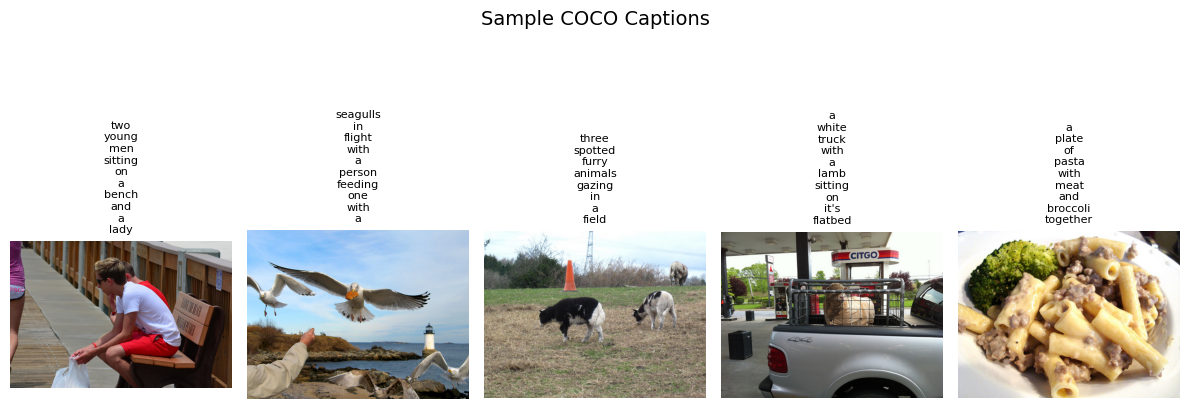

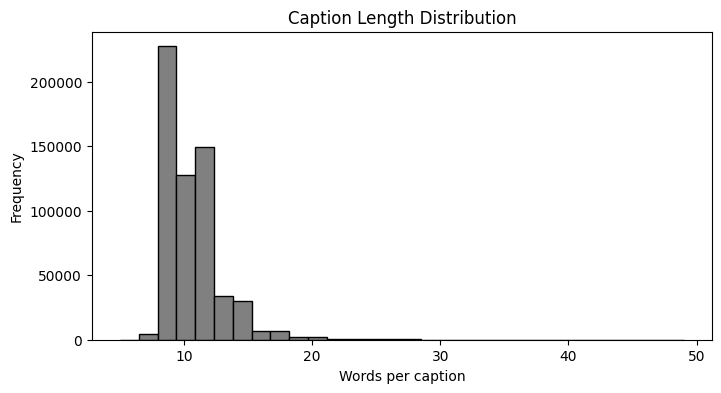

✅ Saved dataset_summary.csv


In [1]:
# ---------------- Notebook-ready 01_data_preparation ----------------
import os, json, random
from pathlib import Path
from collections import Counter
from tqdm import tqdm

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf

# ---------------------------------------------------------------------
# 1️⃣ Paths (notebook-friendly)
# ---------------------------------------------------------------------
CURRENT_DIR = Path.cwd()           # current working directory in notebook
PROJECT_ROOT = CURRENT_DIR.parent  # adjust if your notebook is inside notebooks/
DATA_DIR = PROJECT_ROOT / "data"

IMG_DIR = DATA_DIR / "images" / "train2017"
ANN_PATH = DATA_DIR / "annotations" / "captions_train2017.json"
OUT_DIR = DATA_DIR / "processed_images"
OUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"📁 Data directory: {DATA_DIR}")
print(f"📁 Image directory: {IMG_DIR}")
print(f"📁 Output directory: {OUT_DIR}")

# ---------------------------------------------------------------------
# 2️⃣ Parameters
# ---------------------------------------------------------------------
IMG_SIZE = (299, 299)  # target size for resizing
SAMPLE_PREVIEW = 5     # number of images/captions to show

# ---------------------------------------------------------------------
# 3️⃣ Load COCO captions
# ---------------------------------------------------------------------
print("Loading captions JSON...")
with open(ANN_PATH, "r") as f:
    data = json.load(f)

captions = pd.DataFrame(data["annotations"])
images = pd.DataFrame(data["images"])

print(f"Total images in JSON: {len(images):,}")
print(f"Total captions in JSON: {len(captions):,}")

# Merge captions with filenames
imgid_to_file = {row["id"]: row["file_name"] for _, row in images.iterrows()}
captions["file_name"] = captions["image_id"].map(imgid_to_file)

# ---------------------------------------------------------------------
# 4️⃣ Resize and normalize images
# ---------------------------------------------------------------------
def preprocess_and_save_image(img_path, out_path, target_size=IMG_SIZE):
    """Resize to target size and normalize pixels (0-1)."""
    img = Image.open(img_path).convert("RGB").resize(target_size, Image.BICUBIC)
    arr = np.array(img, dtype=np.float32) / 255.0
    np.savez_compressed(out_path.with_suffix(".npz"), img=arr)

print("🪄 Preprocessing images (this may take a while)...")
processed_count = 0
missing_count = 0

for fname in tqdm(captions["file_name"].unique()[:5000]):  # remove [:5000] for full dataset
    in_path = IMG_DIR / fname
    out_path = OUT_DIR / Path(fname).stem

    if not in_path.exists():
        missing_count += 1
        continue

    if not out_path.with_suffix(".npz").exists():
        try:
            preprocess_and_save_image(in_path, out_path)
            processed_count += 1
        except Exception as e:
            print(f"❌ Error processing {in_path}: {e}")

print(f"✅ Preprocessing complete: {processed_count} images processed, {missing_count} missing.")

# ---------------------------------------------------------------------
# 5️⃣ Caption Cleaning & Tokenization
# ---------------------------------------------------------------------
def clean_caption(c):
    c = c.lower().strip()
    for p in [".", ",", "!", "?", "(", ")", "\"", ";", ":"]:
        c = c.replace(p, "")
    return c

captions["clean_caption"] = captions["caption"].apply(clean_caption)
tokens = [c.split() for c in captions["clean_caption"]]
caption_lengths = [len(t) for t in tokens]

# Vocabulary stats
all_words = [w for cap in tokens for w in cap]
word_counts = Counter(all_words)
vocab_size = len(word_counts)
avg_length = np.mean(caption_lengths)

print(f"Vocabulary size: {vocab_size:,}")
print(f"Average caption length: {avg_length:.2f} words")
print(f"Max caption length: {max(caption_lengths)}")
print(f"Min caption length: {min(caption_lengths)}")

# ---------------------------------------------------------------------
# 6️⃣ Show some random samples
# ---------------------------------------------------------------------
sample_rows = captions.sample(SAMPLE_PREVIEW, random_state=42)

plt.figure(figsize=(12, 6))
for i, row in enumerate(sample_rows.itertuples(), 1):
    img_path = IMG_DIR / row.file_name
    if not img_path.exists():
        continue
    img = Image.open(img_path)
    plt.subplot(1, SAMPLE_PREVIEW, i)
    plt.imshow(img)
    plt.axis("off")
    plt.title("\n".join(row.clean_caption.split()[:10]), fontsize=8)

plt.suptitle("Sample COCO Captions", fontsize=14)
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# 7️⃣ Caption Length Distribution
# ---------------------------------------------------------------------
plt.figure(figsize=(8, 4))
plt.hist(caption_lengths, bins=30, color='gray', edgecolor='black')
plt.title("Caption Length Distribution")
plt.xlabel("Words per caption")
plt.ylabel("Frequency")
plt.show()

# ---------------------------------------------------------------------
# 8️⃣ Save dataset summary
# ---------------------------------------------------------------------
summary = {
    "total_images": len(images),
    "total_captions": len(captions),
    "vocab_size": vocab_size,
    "avg_caption_length": avg_length,
    "max_caption_length": max(caption_lengths),
}
pd.DataFrame([summary]).to_csv(DATA_DIR / "dataset_summary.csv", index=False)
print("✅ Saved dataset_summary.csv")
